In [687]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime as dt
import math
import seaborn as sns

In [2]:
from datetime import datetime

In [155]:
plt.style.use('ggplot')

In [526]:
csv_path = '/Users/pranav/Documents/development/njtransit/csv'

In [554]:
week1 = ['2018_02_05', '2018_02_06', '2018_02_07', '2018_02_08', '2018_02_09', '2018_02_10', '2018_02_11']
week2 = ['2018_02_12', '2018_02_13', '2018_02_14', '2018_02_15', '2018_02_16', '2018_02_17', '2018_02_18']
week3 = ['2018_02_19', '2018_02_20', '2018_02_21', '2018_02_22', '2018_02_23'] #'2018_02_24', '2018_02_25'

In [555]:
all_days = week1 + week2 + week3

In [556]:
df = None
for day in all_days:
    day_df = pd.read_csv('{}/{}.csv'.format(csv_path, day))
    if df is None:
        df = day_df
    else:
        df = df.append(day_df, ignore_index=True)

In [557]:
def clean_delay(sec):
    if sec < 0:
        return 0
    else:
        return sec

# temporarily fix wrong day 
def fix_day(row):
    # wrong day
    if row['delay'] >= (1400*60):
        row['time'] = row['time'] - dt.timedelta(days=1)
        row['delay'] = (row['time'] - row['expected']).total_seconds()
    return row
        
def format_df(df):
    df['expected'] = pd.to_datetime(df['expected'])
    df['time'] = pd.to_datetime(df['time'])

    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df = df.apply(fix_day, axis=1)
    df['delay'] = df['delay'].apply(lambda x: clean_delay(x))/60.0 # clean delay and get delay in minutes
    df['status'] = df['status'].fillna("Estimated")
    return df

In [558]:
df = format_df(df)

In [707]:
trains = df.groupby(['train_id', 'date'])

In [708]:
trains_last = trains.last()

In [709]:
trains_last['day_of_week'] = trains_last['time'].dt.dayofweek

In [710]:
trains_last['hour'] = trains_last['time'].dt.hour
trains_last['sched_hour'] = trains_last['expected'].dt.hour

In [711]:
all_trains = trains_last.copy()

In [712]:
trains_last = trains_last[trains_last['type'] == 'NJ Transit'].copy()

In [713]:
def get_severity(delay):
    if math.isnan(delay):
        return "Unscheduled"
    if 0 <= delay < 3:
        return "On time"
    if 3 <= delay < 6:
        return "3-5 min"
    if 6 <= delay < 10:
        return "6-9 min"
    if 10 <= delay < 20:
        return "10-20 min"
    return "20+ min"

In [714]:
trains_last['severity'] = trains_last['delay'].apply(get_severity)

In [715]:
trains_last.reset_index(level='date', inplace=True)

In [742]:
def plot_severity(train_subset, subset_name, ax=None, boxes=True):
    train_subset = train_subset[train_subset['severity'] != 'Unscheduled'].copy()
    severity_date = train_subset.groupby(['date','severity']).size()
    severity_pcts = severity_date.groupby(level=0).apply(lambda x: x/ float(x.sum()))
    severity_pcts = severity_pcts.unstack()
    severity_pcts.fillna(0, inplace=True)
    exclude_cols = ['On time', 'Unscheduled']
    sum_cols = [c for c in severity_pcts.columns if c not in exclude_cols]
    severity_pcts['Total delayed'] = 0
    for col in sum_cols:     
        severity_pcts['Total delayed'] = severity_pcts[col] + severity_pcts['Total delayed']
    if ax is None:
        ax = severity_pcts.plot(figsize=(13,8), title=subset_name + " NJ Transit Performance (2/5/18 - 2/23/18)")
    else:
        severity_pcts.plot(figsize=(13,8), title=subset_name + " NJ Transit Performance (2/5/18 - 2/23/18)", ax=ax)
#         ax.plot(x=severity_pcts.index, y=['Total delayed','Delayed 3-5 min', 'Delayed 6-9 min', 'Delayed 10+ min'])
    ax.set_ylabel('fraction of trains')
    ax.set_xlabel('day')
    if boxes:
        patch = patches.Rectangle((4.8, 0), 1.4, 1, facecolor="red", alpha=0.1) #weekend 2/10-2/11
        patch1 = patches.Rectangle((11.8, 0), 2.4, 1, facecolor="red", alpha=0.1) #weekend 2/17-2/19 (President's Day)
        ax.add_patch(patch)
        ax.add_patch(patch1)
    return train_subset.groupby('severity').size()/float(len(train_subset))

# System-wide severity

In [743]:
sys_wide = trains_last[trains_last['line'] != 'Princeton Shuttle'].copy()

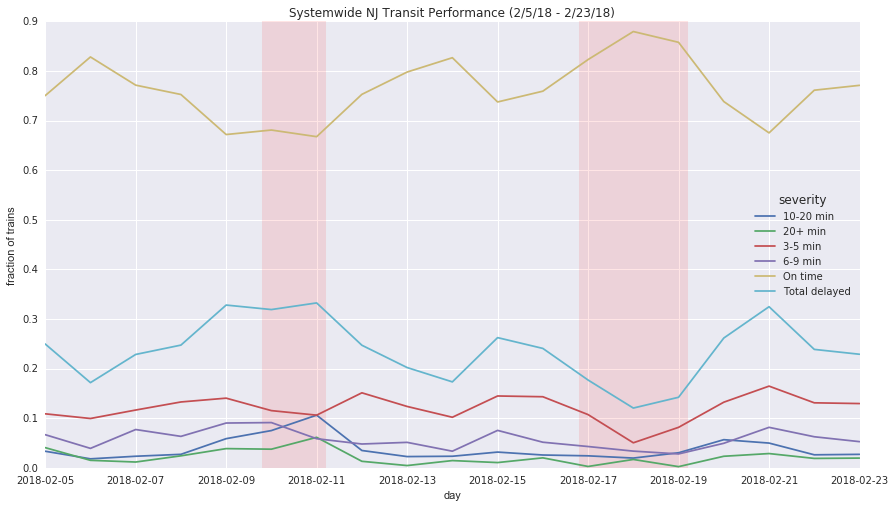

In [744]:
sys_wide_pcts = plot_severity(sys_wide, "Systemwide")

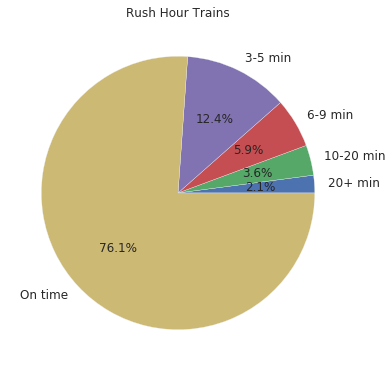

In [745]:

plt.figure(figsize=(12,12))
# plot chart
ax = plt.subplot(121, aspect='equal')
sys_wide_pcts.sort_values().plot(kind="pie", autopct='%1.1f%%', title="Rush Hour Trains", fontsize=12, ax=ax)
ax.set_ylabel('')

In [720]:
# rush hour --> weekdays, between 8-11am
sys_wide_rh = sys_wide[(sys_wide['day_of_week'] >= 1) & \
                       (sys_wide['day_of_week'] <= 5) & \
                       (sys_wide['sched_hour'] >= 8) & \
                       (sys_wide['sched_hour'] <= 10)].copy()

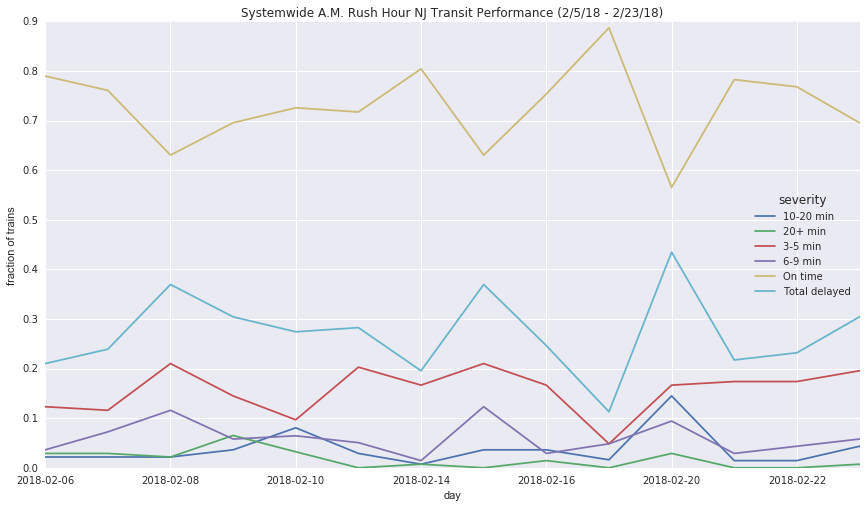

In [721]:
sys_wide_rh_pcts = plot_severity(sys_wide_rh, "Systemwide A.M. Rush Hour", boxes=False)

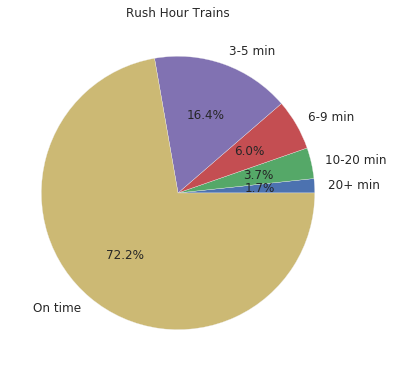

In [737]:
plt.figure(figsize=(12,12))
# plot chart
ax = plt.subplot(121, aspect='equal')
sys_wide_rh_pcts.sort_values().plot(kind="pie", autopct='%1.1f%%', title="Rush Hour Trains", fontsize=12, ax=ax)
ax.set_ylabel('')


In [679]:
1-(0.947**10)

0.41990410793487265

In [680]:
to_nyp_rh = sys_wide_rh[sys_wide_rh['to'] == 'New York Penn Station']

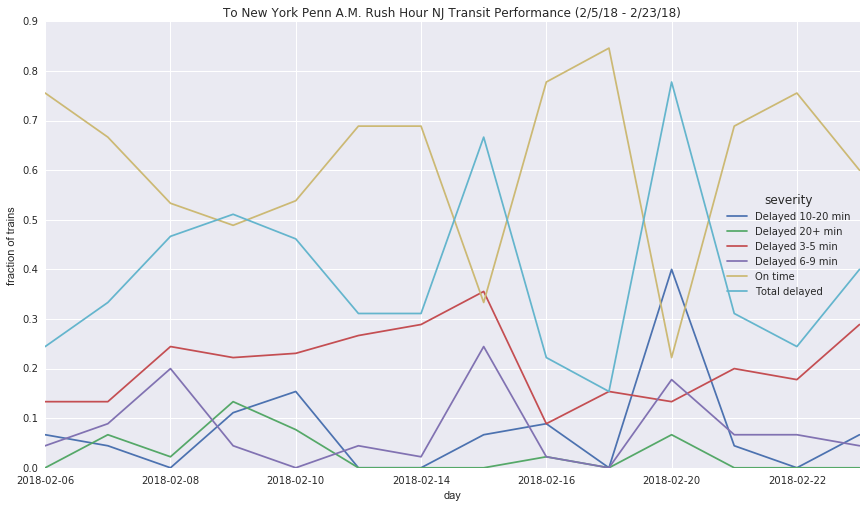

In [688]:
to_nyp_rh_pcts = plot_severity(to_nyp_rh, "To New York Penn A.M. Rush Hour", boxes=False)

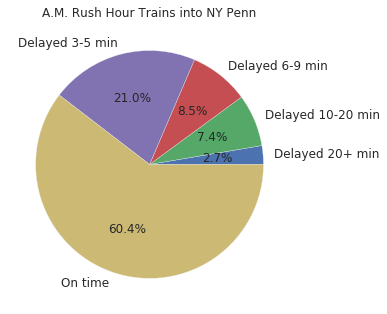

In [740]:
plt.figure(figsize=(10,10))
# plot chart
ax = plt.subplot(121, aspect='equal')
to_nyp_rh_pcts.sort_values().plot(kind="pie", autopct='%1.1f%%', title="A.M. Rush Hour Trains into NY Penn", fontsize=12, ax=ax)
ax.set_ylabel('')

In [738]:
1-(0.899**20)

0.8810967200893366

# NEC severity

In [481]:
nec = trains_last[trains_last['line'] == 'Northeast Corrdr'].copy()

severity
Delayed 10+ min    0.077828
Delayed 3-5 min    0.091855
Delayed 6-9 min    0.058824
On time            0.771493
dtype: float64


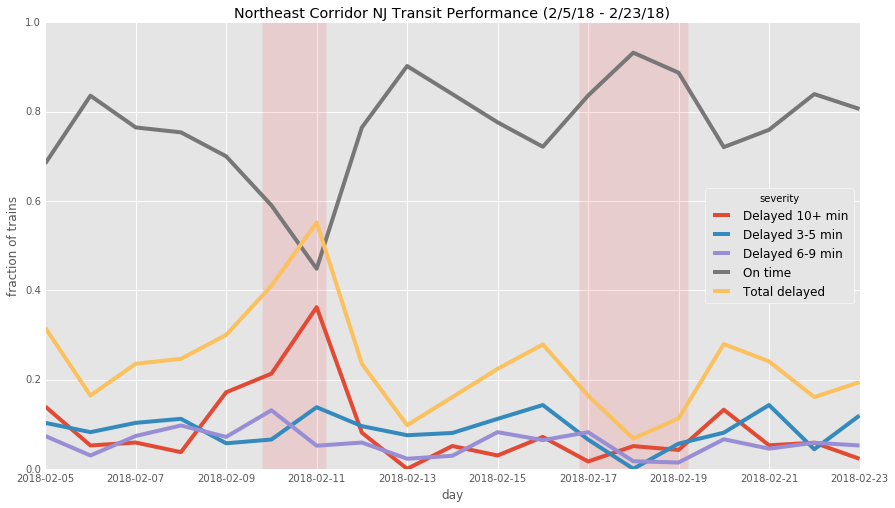

In [482]:
plot_severity(nec, "Northeast Corridor")

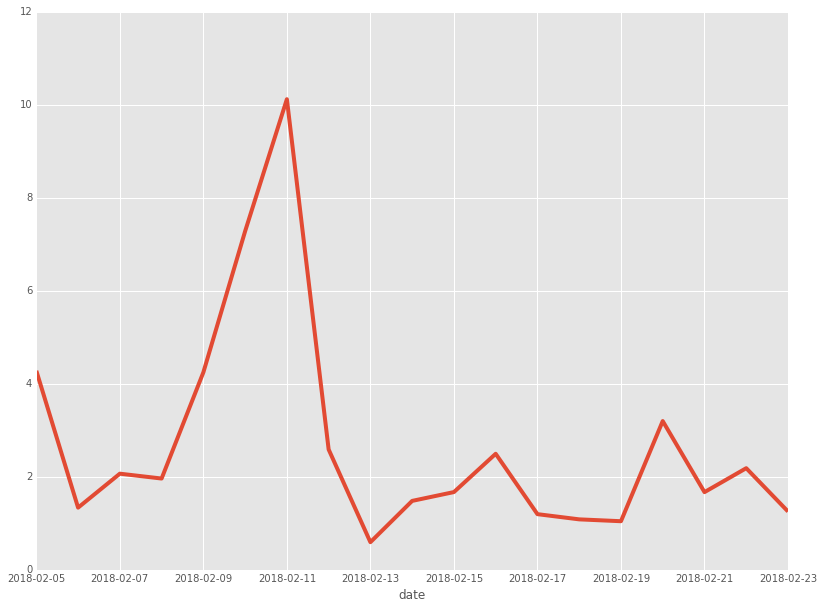

In [487]:
nec.groupby('date')['delay'].mean().plot(figsize=(12,10))

# NJCL Severity

In [446]:
njcl = trains_last[trains_last['line'] == 'No Jersey Coast'].copy()

severity
Delayed 10+ min    0.046765
Delayed 3-5 min    0.101142
Delayed 6-9 min    0.056552
On time            0.795541
dtype: float64


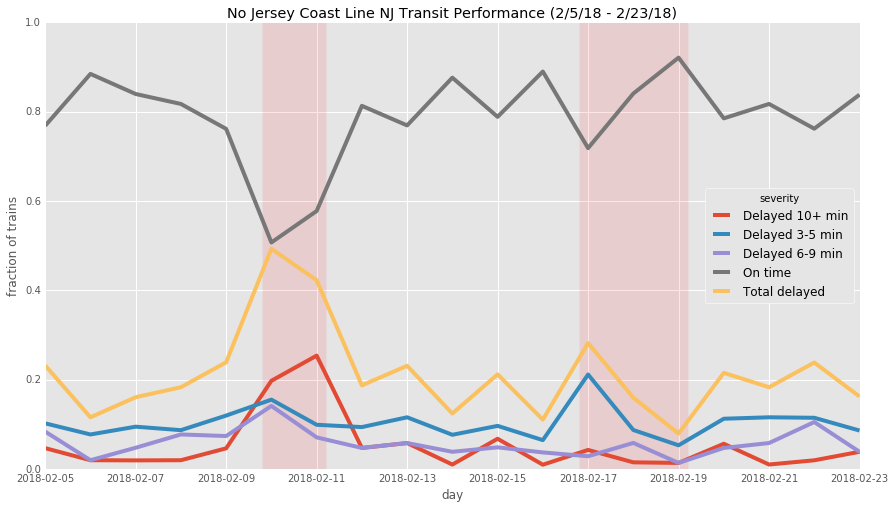

In [447]:
plot_severity(njcl, "No Jersey Coast Line", ax=ax)

# MB Severity

In [373]:
mobo = trains_last[trains_last['line'] == 'Montclair-Boonton'].copy()

severity
Delayed 10+ min    0.039761
Delayed 3-5 min    0.156064
Delayed 6-9 min    0.083499
On time            0.720676
dtype: float64


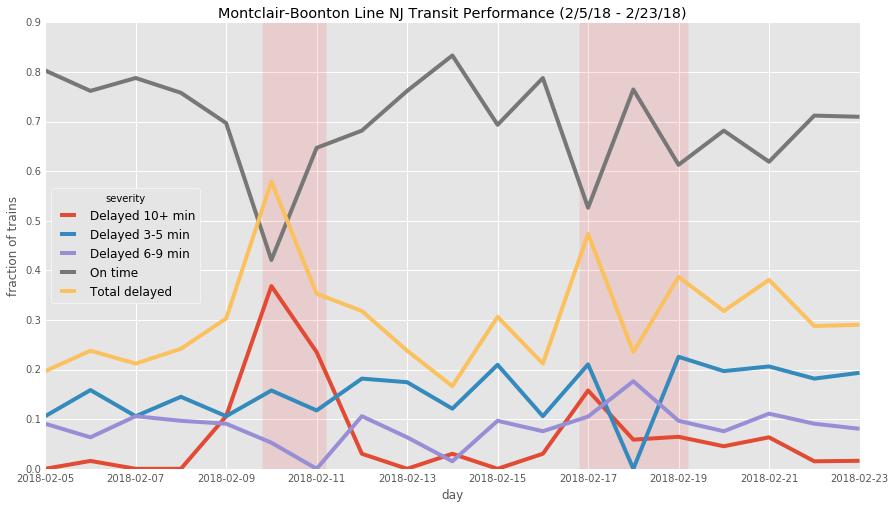

In [374]:
plot_severity(mobo, "Montclair-Boonton Line")

# Gladstone Severity

In [375]:
gladstone = trains_last[trains_last['line'] == 'Gladstone Branch'].copy()

severity
Delayed 10+ min    0.069295
Delayed 3-5 min    0.138590
Delayed 6-9 min    0.058542
On time            0.733572
dtype: float64


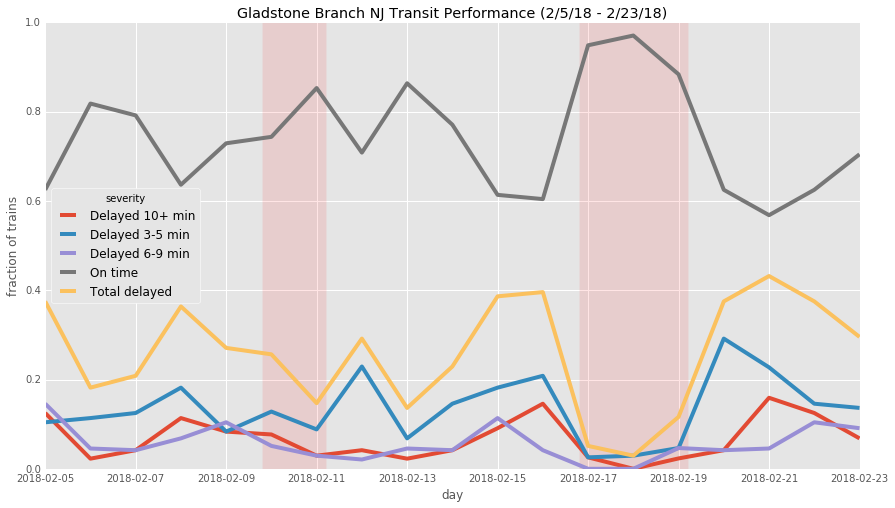

In [376]:
plot_severity(gladstone, 'Gladstone Branch')

# Pascack Severity

In [377]:
pascack = trains_last[trains_last['line'] == 'Pascack Valley'].copy()

severity
Delayed 10+ min    0.021572
Delayed 3-5 min    0.115562
Delayed 6-9 min    0.024653
On time            0.838213
dtype: float64


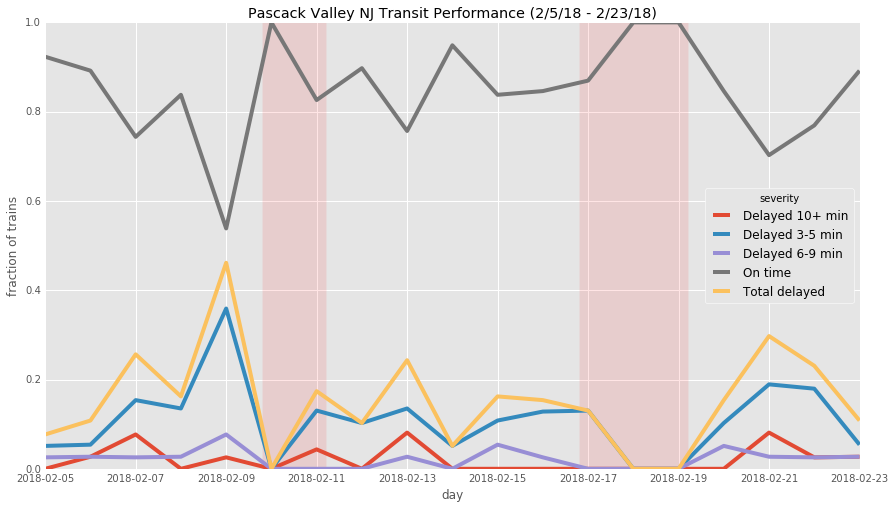

In [378]:
plot_severity(pascack, 'Pascack Valley')

# Raritan Severity

In [379]:
raritan = trains_last[trains_last['line'] == 'Raritan Valley'].copy()

severity
Delayed 10+ min    0.019016
Delayed 3-5 min    0.073826
Delayed 6-9 min    0.033557
On time            0.873602
dtype: float64


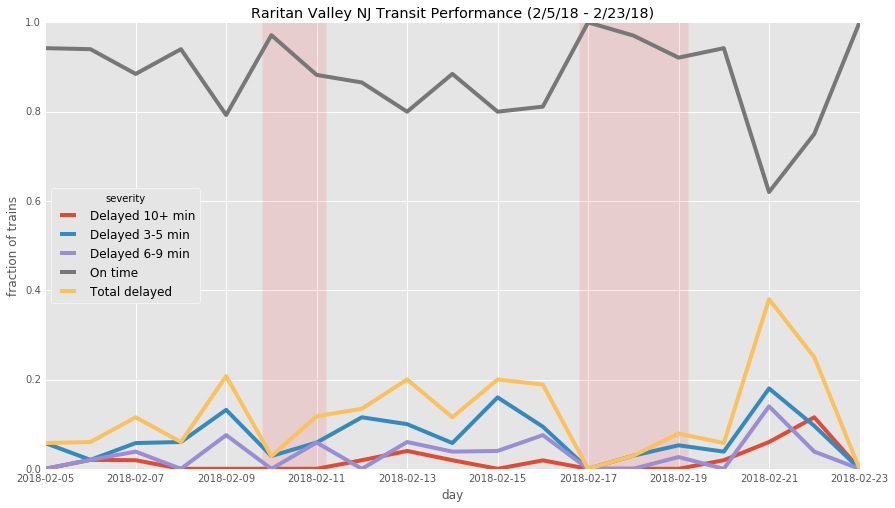

In [380]:
plot_severity(raritan, 'Raritan Valley')

# Bergen Line

In [381]:
bergen = trains_last[trains_last['line'] == 'Bergen Co. Line '].copy()

severity
Delayed 10+ min    0.048255
Delayed 3-5 min    0.154004
Delayed 6-9 min    0.042094
On time            0.755647
dtype: float64


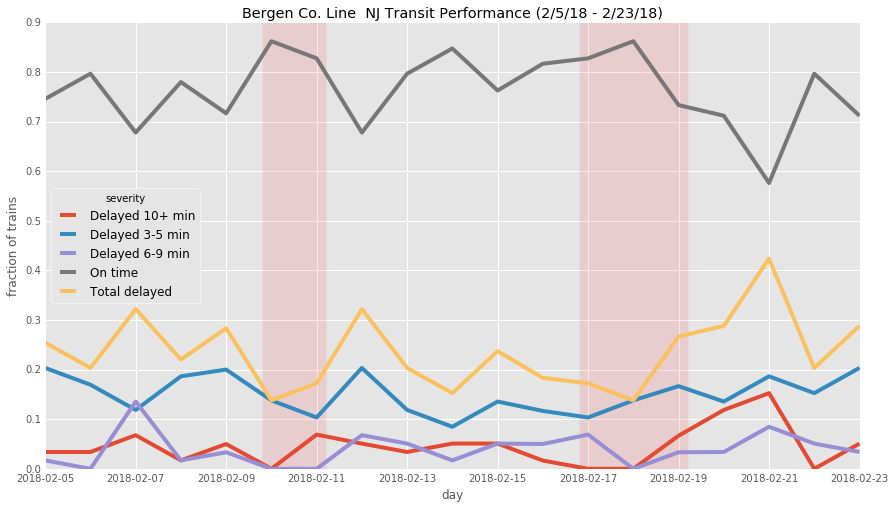

In [382]:
plot_severity(bergen, 'Bergen Co. Line ')

# Main Line

In [383]:
main = trains_last[trains_last['line'] == 'Main Line'].copy()

severity
Delayed 10+ min    0.041534
Delayed 3-5 min    0.170394
Delayed 6-9 min    0.064963
On time            0.723110
dtype: float64


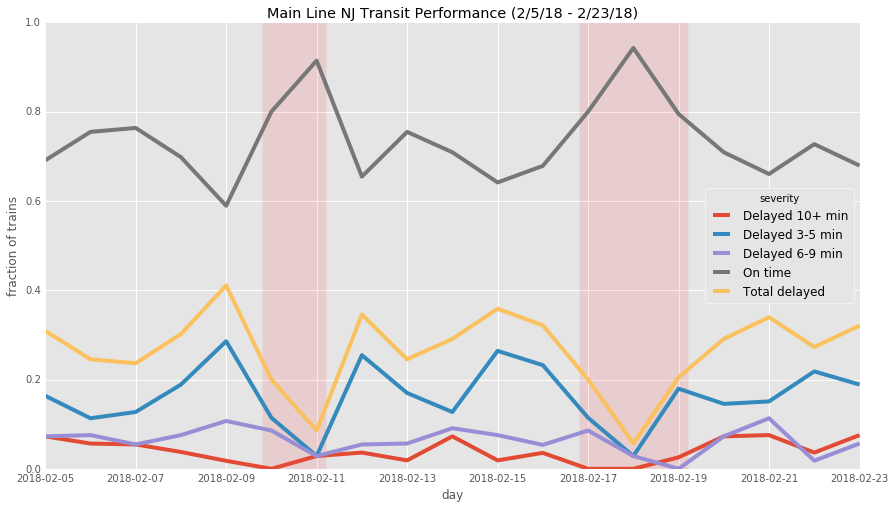

In [384]:
plot_severity(main, 'Main Line')

# Atlantic City Line

In [422]:
ac = trains_last[trains_last['line'] == 'Atl. City Line'].copy()

severity
Delayed 10+ min    0.222738
Delayed 3-5 min    0.199536
Delayed 6-9 min    0.127610
On time            0.443155
Unscheduled        0.006961
dtype: float64


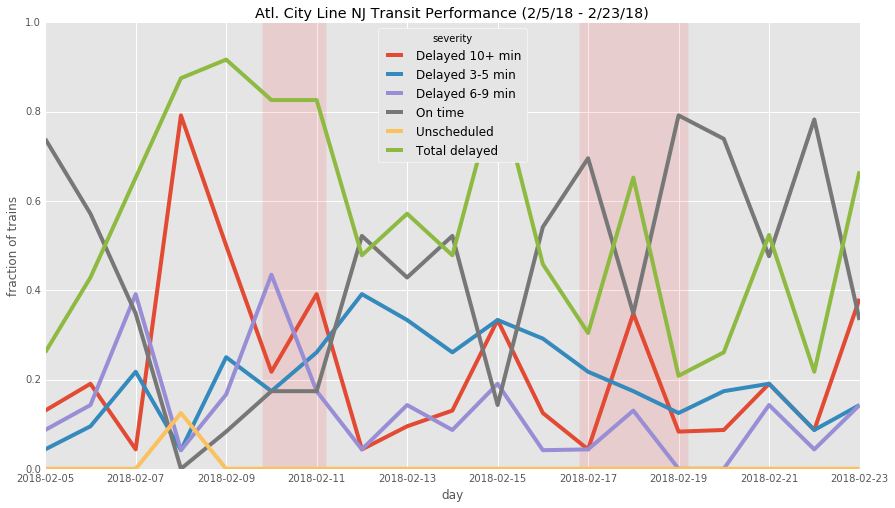

In [423]:
plot_severity(ac, 'Atl. City Line')

In [400]:
type(ac[ac['date']=='2018-02-08'].iloc[-1][-2])

numpy.float64

# Morristown Line

In [388]:
morris = trains_last[trains_last['line'] == 'Morristown Line'].copy()

severity
Delayed 10+ min    0.046440
Delayed 3-5 min    0.130031
Delayed 6-9 min    0.060062
On time            0.763467
dtype: float64


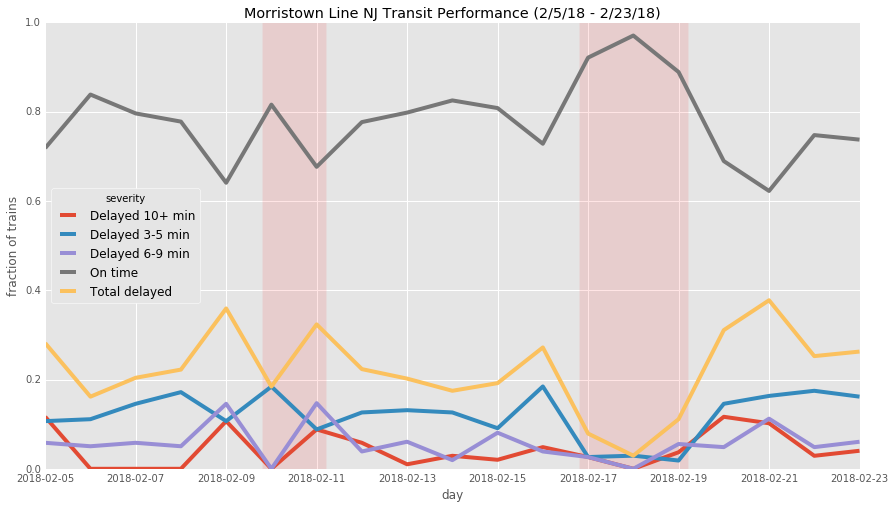

In [389]:
plot_severity(morris, 'Morristown Line')

# Dinky Line

In [419]:
dinky = trains_last[trains_last['line'] == 'Princeton Shuttle'].copy()

In [420]:
dinky.groupby('severity').size()

severity
Delayed 6-9 min       5
On time            1389
dtype: int64

severity
Delayed 6-9 min    0.003587
On time            0.996413
dtype: float64


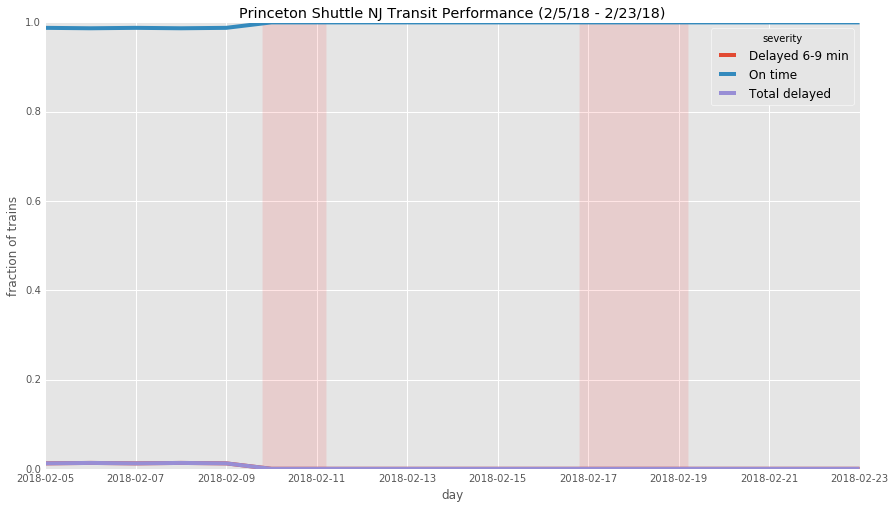

In [421]:
plot_severity(dinky, 'Princeton Shuttle')

# All Trains Volume

In [505]:
all_nec = all_trains[(all_trains['line'].isin(['Northeast Corrdr','No Jersey Coast'])) | (all_trains['type'] == "Amtrak")].copy()

In [507]:
def get_line_proxy(row):
    if row['type'] == 'Amtrak':
        row['proxy_line'] = 'Amtrak'
    elif row['line'] == 'Northeast Corrdr':
        row['proxy_line'] = 'Northeast Corrdr'
    else:
        row['proxy_line'] = 'No Jersey Coast'
    return row

In [508]:
all_nec = all_nec.apply(get_line_proxy, axis=1)

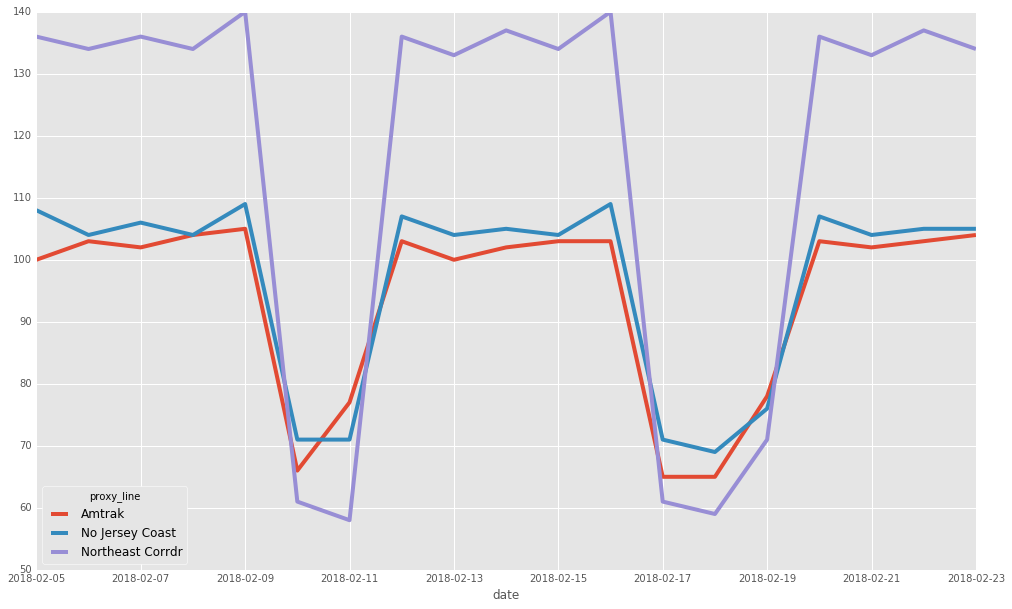

In [509]:
all_nec.groupby(['date', 'proxy_line']).size().unstack().plot(figsize=(15,10))